<h1 align="center"><font color="yellow">Zero-shot, Few-shot and Prompt chaining using Langchain</font></h1>

<font color="yellow">Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro</font>

# [O que é LangChain](https://blog.gopenai.com/zeroshot-fewshot-and-prompt-chaining-using-langchain-4259d700d67f)

<font color="orange">Langchain é uma estrutura para desenvolvimento de aplicativos usando `LLMs`. Ele funciona como um `wrapper` para conexão com diferentes LLMs e abstrai a comunicação real entre seu aplicativo e o modelo de linguagem. Também pode funcionar como um compositor/orquestrador que reúne informações de diferentes modelos (ou mesmo sites via `agente`) e as combina para formar o resultado final do modelo.</font>

# <font color="red">Zero-shot Prompting</font>

O `prompt zero-shot` é um tipo de tarefa de processamento de linguagem natural (`NLP`) em que um modelo recebe um prompt e espera-se que gere um texto relevante para o prompt, mesmo que o modelo nunca tenha visto o prompt antes. `Por exemplo`, se a solicitação for `“Conte-me uma piada sobre um casal”`, espera-se que o modelo gere uma piada sobre um casal, mesmo que o modelo nunca tenha visto tal piada antes.

In [1]:
import os
import openai
import tiktoken
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [4]:
def get_prompt_template():
    return """
        Quero que você desempenhe o papel de um bot de viagens e responda à \
        pergunta. Retorne a resposta em formato json, você deve fornecer apenas três opções \
        listadas em uma estrutura de array. A raiz do array deve ser nomeada como "opções". \
        Você mesmo deve preencher os valores e remover opções inviáveis ou não fatíveis do json.        
        
        question: {question}
        """


In [5]:
import os
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import json

class ZeroShotUtility:
    def __init__(self, template, temperature=0.0):
        self.template = template
        self.temperature = temperature

    def __str__(self):
        return f"{self.template}"

    def print_travel_modes(self, question):
        prompt_template = ChatPromptTemplate.from_template(self.template)
        message = prompt_template.format_messages(question=question)

        llm = ChatOpenAI(temperature=self.temperature, 
                         openai_api_key=os.getenv("OPENAI_KEY"))
        response = llm(message)
        
        print(response.content)
    

In [6]:
prompt_template = get_prompt_template()

zeroshotutility = ZeroShotUtility(prompt_template)


question = "Como chegar à cidade de Lima-Perú saindo de Vitória-ES Brasil?"
zeroshotutility.print_travel_modes(question=question)


{
  "opções": [
    "Opção 1: Voar de Vitória-ES para Lima-Perú",
    "Opção 2: Pegar um voo de Vitória-ES para São Paulo-SP e depois voar de São Paulo-SP para Lima-Perú",
    "Opção 3: Pegar um voo de Vitória-ES para Rio de Janeiro-RJ e depois voar de Rio de Janeiro-RJ para Lima-Perú"
  ]
}


<font color="orange">`OBSERVAÇÃO:`

Tenha cuidado com uso de `zero-shot`, já que têm muitos casos em que a estrutura da answer pode ser alterada. Portanto, se você deseja ter a answer em um formato específico ou se deseja que sua answer seja mais padronizada, o `zero-shot` pode não funcionar o tempo todo.</font>

# <font color="red">Few-shot Prompting</font>

O `few-shot prompt` é um tipo de tarefa de processamento de linguagem natural (`NLP`) em que um modelo recebe um `prompt` e `alguns exemplos de texto` e espera-se que gere texto que seja relevante para o prompt e `semelhante aos exemplos`.

<font color="orange">A seguir, forneceremos alguns exemplos sobre o tipo de resultado que desejamos. Além disso, você verá um `prefixo` e um `sufixo` apenas para separar a questão real dos exemplos no prompt (e para seguir a assinatura do método da biblioteca `Langchain`.)</font>

In [76]:
class FewShot:

    @staticmethod
    def get_examples():
        examples = [ 
            { 
                "question" : "Como chegar ao aeroporto de Calcutá até o Zoológico de Calcutá?" , 
                "answer" : """ 
                opção 1: mode=bus, min_time_in_min=75, max_time_in_min=90, description=pegue o ônibus nº 37 do aeroporto. Ele o deixará 
                em Alipore. Faça uma caminhada de 5 minutos, 
                opção 2: mode= metro, min_time_in_min=40, max_time_in_min=60, description=pegue o metrô do aeroporto. Ele 
                o deixará em Joka. Faça uma caminhada de 10 minutos
                opção 3: mod=trem, min_time_in_min=45, max_time_in_min=60, description=pegar o trem local do aeroporto. Isso 
                o deixará em Nova Alipore. Faça uma caminhada de 10 minutos, 
                opção 4: mod=walk, min_time_in_min=400, max_time_in_min=500, description=take Faça uma caminhada de 500 minutos 
                """
             }, 
            { 
                "year" : "Como chegar ao aeroporto de Hyderabad até Hyderabad HiTech City ?" , 
                "answer" : """ 
                opção 1: mode=bus, min_time_in_min=60, max_time_in_min=75, description=pegue o ônibus nº 23 do aeroporto. Isso 
                o deixará na cidade de alta tecnologia.
                opção 2: mode=car, min_time_in_min=30, max_time_in_min=45, description=pegar transporte ola/uber/aeroporto. 
                Ele o deixará na 
                opção 3 da cidade HiTech: mode=motorbike, min_time_in_min=25, max_time_in_min=40. description=pegue uma moto.Ela 
                o deixará na cidade HiTech 
                """
             }, 
            { 
                "question" : "Como chegar ao aeroporto de Heathrow até Hounslow Central?" , 
                "answer" : """ 
                        opção 1: mode=tube, min_time_in_min= 10, max_time_in_min=15. description=pegue o metrô no aeroporto.

                        opção 2: mode=carro, min_time_in_min=25, max_time_in_min=35. description=pegue um carro alugado no 
                         aeroporto. Ele irá deixá-lo em Hounslow Central 
                        """
             } 
        ]
        return examples

    @staticmethod
    def get_example_template():
        template = """
        Pergunta: {question}
        Resposta: {answer}
        """
        example_variables = ["question", "answer"]
        return template, example_variables

    @staticmethod
    def get_prefix():
        return f"""
        Quero que você desempenhe o papel de um bot de viagens e responda à \
        pergunta. Retorne a resposta em formato json, você deve fornecer apenas seis opções \
        listadas em uma estrutura de array. A raiz do array deve ser nomeada como "opções". \
        Você mesmo deve preencher os valores e remover opções inviáveis ou não fatíveis do json.
        """

    @staticmethod
    def get_suffix():
        return """
                Pergunta: {question}
                """

In [77]:
import os
from langchain import PromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate


class FewShotUtility:

    def __init__(self, examples, prefix, suffix, input_variables, example_template, example_variables):
        self.examples = examples
        self.prefix = prefix
        self.suffix = suffix
        self.input_variables = input_variables
        self.example_template = example_template
        self.example_variables = example_variables

    def get_prompt(self, question):
        prompt_template = FewShotPromptTemplate(
            examples=self.examples,
            example_prompt=self.get_prompt_template(),
            prefix=self.prefix,
            suffix=self.suffix,
            input_variables=self.input_variables
        )
        prompt = prompt_template.format(question=question)
        return prompt

    def get_prompt_template(self):
        example_prompt = PromptTemplate(
            input_variables=self.example_variables,
            template=self.example_template
        )
        return example_prompt

    @staticmethod
    def print_travel_modes(prompt):
        prompt_template = ChatPromptTemplate.from_template(prompt)
        message = prompt_template.format_messages()
        llm = ChatOpenAI(temperature=0, openai_api_key=os.getenv("OPENAI_KEY"))
        response = llm(message)
        print(response.content)


In [78]:
fewshot = FewShot() # Instancio a Classe

examples = fewshot.get_examples()
prefix = fewshot.get_prefix()
suffix = fewshot.get_suffix()
example_template, example_variables = fewshot.get_example_template()


fewShot = FewShotUtility(examples=examples,
                         prefix=prefix,
                         suffix=suffix,
                         input_variables=["question"],
                         example_template=example_template,
                         example_variables=example_variables
                        )


question = "Como chegar à cidade de Lima-Perú saindo de Vitória-ES Brasil?"
prompt = fewShot.get_prompt(question)
fewShot.print_travel_modes(prompt)


Resposta:  
                opção 1: mode=avião, min_time_in_min=360, max_time_in_min=420, description=pegue um voo direto de Vitória para Lima. 
                opção 2: mode=ônibus, min_time_in_min=1440, max_time_in_min=1800, description=pegue um ônibus de Vitória para Lima. 
                opção 3: mode=carro, min_time_in_min=4320, max_time_in_min=5040, description=dirija de Vitória para Lima. 
                opção 4: mode=trem, min_time_in_min=7200, max_time_in_min=8640, description=pegue um trem de Vitória para Lima. 
                opção 5: mode=barco, min_time_in_min=43200, max_time_in_min=50400, description=faça uma viagem de barco de Vitória para Lima. 
                opção 6: mode=bicicleta, min_time_in_min=129600, max_time_in_min=151200, description=faça uma viagem de bicicleta de Vitória para Lima.


# <font color="red">Prompt Chaining</font>

<font color="orange">Pelo próprio nome você deve ter adivinhado a intenção desta seção. Isso também é conhecido como `prompt de cadeia de pensamentos`, onde um problema complexo pode ser subdividido em várias etapas intermediárias e o resultado final será composto (então, no termo de matemática, você está fazendo derivadas antes de fazer a integração.). Vamos nos aprofundar no conceito:</font>

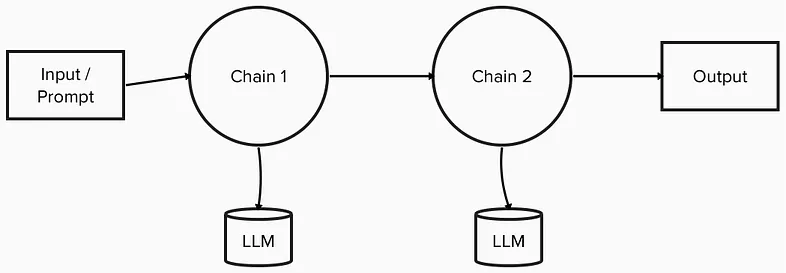

<font color="orange">A imagem acima mostra uma `Chain sequencial simples` (Simple Sequential Chain):

`Passo 1:` O usuário digita no prompt

`Passo 2:` A cadeia 1 pega o prompt e, usando o LLM subjacente, calcula a saída

`Passo 3:` A saída da cadeia 1 é então alimentada para a Cadeia 2, que também usa LLM (igual ou diferente) e produz a saída final.</font>

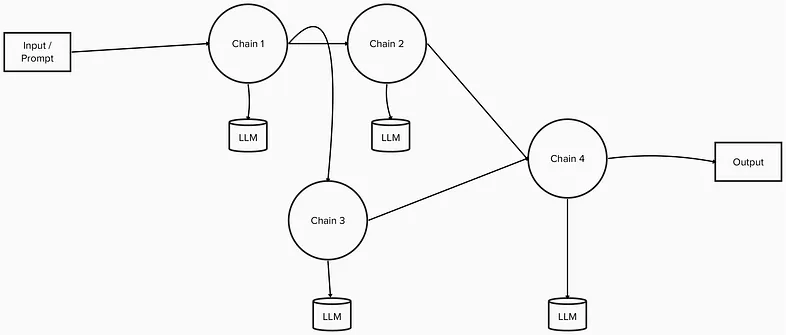

A imagem acima mostra uma `cadeia sequencial complexa` onde as sequências são orquestradas:

`Passo 1:` O usuário digita no prompt

`Passo 2:` A `cadeia 1` pega o prompt e, usando o `LLM subjacente`, calcula a saída. Esta saída é alimentada em duas cadeias diferentes $→$ `Cadeia 2` e `Cadeia 3`

`Passo 3:` A `Cadeia 2` e a `Cadeia 3` calculam os resultados com base na entrada e a saída de ambas é alimentada na `Cadeia 4`

`Passo 4:` A `cadeia 4`` calcula o resultado usando a entrada e produz a saída final

Agora vamos tentar implementar o mesmo. Vamos improvisar no nosso exemplo de viagem.

Começaremos criando `três prompts diferentes` e os encadearemos sequencialmente para formar a cadeia geral. Em seguida, usaremos a cadeia geral para chegar ao resultado final. Aqui está a aparência dos meus três prompts:

In [7]:
class SeqChainPrompt:

    @staticmethod
    def get_first_template():
        return """
        Quero que você desempenhe o papel de um bot de viagens e responda à \
        pergunta. Retorne a resposta em formato json, você deve fornecer apenas três opções \
        listadas em uma estrutura de array. A raiz do array deve ser nomeada como "opções". \
        Você mesmo deve preencher os valores e remover opções inviáveis ou não fatíveis do json.
        Você deve incluir pelo menos modo, duração e preço em sua saída.

        Question: {question}
        """

    @staticmethod
    def get_second_template(input_key):
        key = "{" + input_key + "}"
        return f"""
        Dos Travel_Modes fornecidos, extraia os 2 modos em que o tempo de \
        viagem é máximo e o tempo de viagem é mínimo. Retorne a resposta \
        em formato json como a entrada Travel_Modes: {key}
        """

    @staticmethod
    def get_third_template(input_key):
        key = "{" + input_key + "}"
        return f"""
        Das opções fornecidas, escreva um documento resumido sobre como um viajante pode chegar ao destino
        Options: {key}
        """

Como você pode ver acima, os PROMPTs são autoexplicativas e não há nada para discutir aqui.

Agora usaremos a biblioteca `Langchain` para criar cadeias e nos comunicarmos com o modelo para calcular os resultados. Aqui está como é a `Classe`:

In [8]:
from langchain.chains import SequentialChain, LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import os


class ChainUtility:

    def __init__(self, input_variables, temperature=0):
        self.input_variables = input_variables
        self.temperature = temperature

    def get_chain(self, template, output_key):
        llm = ChatOpenAI(temperature=self.temperature, openai_api_key=os.getenv("OPENAI_KEY"))
        prompt = ChatPromptTemplate.from_template(template)
        
        chain = LLMChain(llm=llm, prompt=prompt,
                         output_key=output_key
                         )
        return chain

    def get_overall_chain(self, chains, output_variables):
        overall_chain = SequentialChain(
            chains=chains,
            input_variables=self.input_variables,
            output_variables=output_variables,
            verbose=True
        )
        return overall_chain

    @staticmethod
    def print_completion(chain, start):
        resp = chain(start)
        print(resp)

<font color="orange">Agora vamos ver como podemos usar os `Templates de prompt` e este utilitário langchain para chegar ao resultado final. Aqui está nossa classe:</font>

In [14]:
# seqchainutility = ChainUtility()
# seqchain = SeqChainPrompt()

chains = []
output_variables = []
input_variables = ["question"]

#chainUtility = seqchainutility.ChainUtility(input_variables=input_variables)
chainUtility = ChainUtility(input_variables=input_variables)

question_template = SeqChainPrompt.get_first_template()
output_key = "travel_modes"
output_variables.append(output_key)
question_chain = chainUtility.get_chain(template=question_template, output_key=output_key)
chains.append(question_chain)

travel_modes_template = SeqChainPrompt.get_second_template(output_key)
output_key = "options"
output_variables.append(output_key)
travel_mode_chain = chainUtility.get_chain(template=travel_modes_template, output_key=output_key)
chains.append(travel_mode_chain)

options_template = SeqChainPrompt.get_third_template(output_key)
output_key = "travel_advice"
output_variables.append(output_key)
options_chain = chainUtility.get_chain(template=options_template, output_key=output_key)
chains.append(options_chain)

overall_chain = chainUtility.get_overall_chain(chains=chains, output_variables=["travel_modes", "options",
                                                                                   "travel_advice"])

startQuestion = "Como chegar à cidade de Lima-Perú saindo de Vitória-ES Brasil?"
chainUtility.print_completion(overall_chain,start=startQuestion)




> Entering new SequentialChain chain...

> Finished chain.
{'question': 'Como chegar à cidade de Lima-Perú saindo de Vitória-ES Brasil?', 'travel_modes': '{\n  "opções": [\n    {\n      "modo": "Avião",\n      "duração": "8 horas",\n      "preço": "R$ 2.000"\n    },\n    {\n      "modo": "Ônibus",\n      "duração": "3 dias",\n      "preço": "R$ 500"\n    },\n    {\n      "modo": "Carro",\n      "duração": "5 dias",\n      "preço": "R$ 1.500"\n    }\n  ]\n}', 'options': 'A partir dos dados fornecidos, podemos identificar que o modo de viagem com o tempo máximo é o avião, com duração de 8 horas, e o modo de viagem com o tempo mínimo é o ônibus, com duração de 3 dias. \n\nA resposta em formato JSON seria:\n\n{\n  "Travel_Modes": {\n    "opções": [\n      {\n        "modo": "Avião",\n        "duração": "8 horas",\n        "preço": "R$ 2.000"\n      },\n      {\n        "modo": "Ônibus",\n        "duração": "3 dias",\n        "preço": "R$ 500"\n      }\n    ]\n  }\n}', 'travel_advice': 'A

Se você se concentrar na penúltima linha, verá que esta é a única entrada que estamos fornecendo. Usando esta entrada estamos criando `três cadeias`.


1. Na primeira cadeia (`question_chain`) estamos passando esta questão e esperamos que todos os modos de viagem sejam retornados em formato `json`.

2. Na segunda cadeia (`travel_mode_chain`) estamos passando a saída da primeira cadeia como uma entrada e esperamos que ela retorne apenas `dois modos de viagem` onde o tempo de viagem é máximo e mínimo. O retorno deverá estar novamente no formato `json`.

3. Na terceira cadeia (`options_chain`) estamos passando a saída da segunda cadeia como entrada e esperamos retornar um bom resumo como nossa resposta final


Ao formar o `overall_chain`, passamos nossa entrada como perguntas e na saída queremos ver todos os três resultados saindo da cadeia. Assim, passamos toda a saída de cadeias individuais na variável de saída.

# A OpenAI foi treinado só até o Setembro 2021

In [58]:
import os
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

class ZeroShot:

    @staticmethod
    def get_prompt_template():
        return """
        Quero que você faça o papel de um jornalista esportivo. \
        Você pode me dizer quem ganhou a Copa do Mundo da FIFA no ano especificado? \
        Se você não sabe, simplesmente responda: ' Não sei sobre isso' 
        
        Ano: {year}
        """

class ZeroShotUtility:
    def __init__(self, template, temperature=0.0):
        self.template = template
        self.temperature = temperature

    def __str__(self):
        return f"{self.template}"

    def print_travel_modes(self, year):
        prompt_template = ChatPromptTemplate.from_template(self.template)
        message = prompt_template.format_messages(year=year)

        llm = ChatOpenAI(temperature=self.temperature, 
                         openai_api_key=os.getenv("OPENAI_KEY"))
        response = llm(message)
        
        print(response.content)    

In [61]:
eddy_zeroshot  = ZeroShot()
eddy_prompt_template = eddy_zeroshot.get_prompt_template()


zeroshotutility = ZeroShotUtility(eddy_prompt_template)
zeroshotutility.print_travel_modes(year=2022)

Desculpe, mas como sou um modelo de linguagem treinado até setembro de 2021, não tenho informações sobre eventos futuros, como a Copa do Mundo da FIFA em 2022. Portanto, não posso fornecer a resposta que você está procurando.
